# Inferencia de Serie Temporal COVID-19 con Modelo Híbrido

Este notebook realiza una inferencia sobre la serie temporal de COVID-19 para un país específico utilizando el modelo híbrido XGBoost-LSTM entrenado.

## Modelo
- **Etapa 1**: Clasificador XGBoost que predice el régimen epidemiológico (Bajada/Estable/Subida)
- **Etapa 2**: Red LSTM especializada que predice la magnitud de casos para los próximos 7 días

In [52]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurar paths
sys.path.append('../modelo')

# Importar componentes del modelo
from hybrid_model import HybridCOVIDModel
from config import HybridConfig
from feature_engineering import extract_features

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Cargar Modelo Entrenado

In [53]:
# Crear instancia del modelo
config = HybridConfig()
model = HybridCOVIDModel(config=config)

# Cargar pesos del modelo entrenado
model_path = '../modelos/hybrid_covid_model_completo'
model.load(
    path_prefix=model_path,
    input_size=4,  # 4 features: cases, deaths, reproduction_rate, positive_rate
    output_size=7  # Predicción para 7 días
)

print("✓ Modelo cargado exitosamente")

✓ Clasificador cargado desde ../modelos/hybrid_covid_model_completo_classifier.pkl
  ✓ Predictor 'bajada' cargado desde ../modelos/hybrid_covid_model_completo_predictor_bajada.pth
  ✓ Predictor 'estable' cargado desde ../modelos/hybrid_covid_model_completo_predictor_estable.pth
  ✓ Predictor 'subida' cargado desde ../modelos/hybrid_covid_model_completo_predictor_subida.pth

✓ Modelo híbrido completo cargado desde: ../modelos/hybrid_covid_model_completo
✓ Modelo cargado exitosamente


## 2. Cargar y Preparar Datos

Vamos a cargar los datos de COVID-19 desde Our World in Data y filtrar por los países incluidos en el entrenamiento.

In [54]:
# URL del dataset de Our World in Data
COVID_URL = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"

# Cargar datos completos
print("Descargando datos de COVID-19 desde Our World in Data...")
df = pd.read_csv(COVID_URL)
print(f"✓ Dataset completo cargado: {df.shape}")

# Cargar lista de países incluidos
with open('../paises_incluidos.txt', 'r') as f:
    paises_incluidos = [line.strip() for line in f.readlines()]

print(f"\n✓ Países incluidos en entrenamiento: {len(paises_incluidos)}")

# Filtrar solo países incluidos
df = df[df['country'].isin(paises_incluidos)].copy()
print(f"✓ Dataset filtrado: {df.shape}")

# Renombrar columna para consistencia
df = df.rename(columns={'country': 'location'})

print(f"\nColumnas disponibles: {list(df.columns)[:15]}...")
print(f"Países únicos: {df['location'].nunique()}")
print(f"\nPrimeras filas:")
df.head()

Descargando datos de COVID-19 desde Our World in Data...
✓ Dataset completo cargado: (535365, 61)

✓ Países incluidos en entrenamiento: 135
✓ Dataset filtrado: (283893, 61)

Columnas disponibles: ['location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'excess_mortality']...
Países únicos: 135

Primeras filas:


,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,...,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
0,Afghanistan,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578847.0,62.215549,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
1,Afghanistan,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578847.0,62.215549,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
2,Afghanistan,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578847.0,62.215549,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
3,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,40578847.0,62.215549,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
4,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,40578847.0,62.215549,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN


## 3. Seleccionar País y Preparar Datos

Seleccionamos **España** para realizar la inferencia.

In [55]:
# Seleccionar país
PAIS_SELECCIONADO = 'Spain'

# Filtrar datos del país
df_pais = df[df['location'] == PAIS_SELECCIONADO].copy()
df_pais = df_pais.sort_values('date').reset_index(drop=True)

print(f"País seleccionado: {PAIS_SELECCIONADO}")
print(f"Número de días con datos: {len(df_pais)}")
print(f"Rango de fechas: {df_pais['date'].min()} a {df_pais['date'].max()}")

# Verificar columnas necesarias
required_cols = ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                 'reproduction_rate', 'positive_rate']
missing_cols = [col for col in required_cols if col not in df_pais.columns]
if missing_cols:
    print(f"\n⚠️ Columnas faltantes: {missing_cols}")
else:
    print("\n✓ Todas las columnas necesarias están presentes")

País seleccionado: Spain
Número de días con datos: 2111
Rango de fechas: 2020-01-01 a 2025-12-28

✓ Todas las columnas necesarias están presentes


## 4. Visualizar Serie Temporal Completa

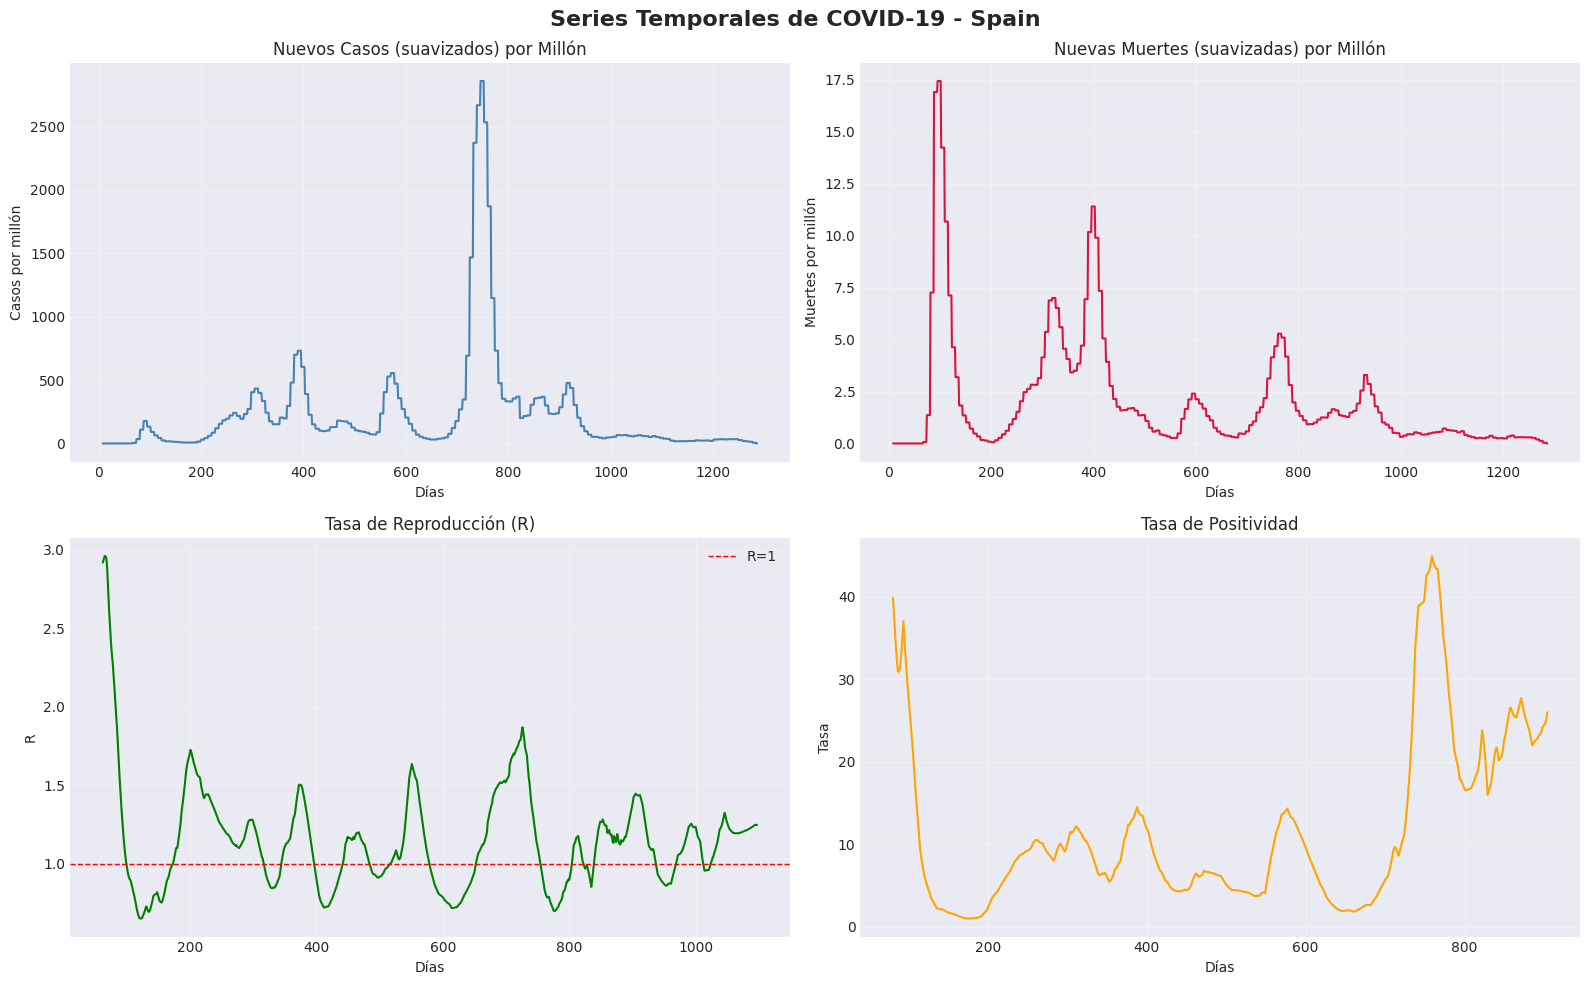

In [56]:
# Visualizar la serie temporal completa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Series Temporales de COVID-19 - {PAIS_SELECCIONADO}', fontsize=16, fontweight='bold')

# Casos
axes[0, 0].plot(df_pais.index, df_pais['new_cases_smoothed_per_million'], color='steelblue', linewidth=1.5)
axes[0, 0].set_title('Nuevos Casos (suavizados) por Millón')
axes[0, 0].set_xlabel('Días')
axes[0, 0].set_ylabel('Casos por millón')
axes[0, 0].grid(alpha=0.3)

# Muertes
axes[0, 1].plot(df_pais.index, df_pais['new_deaths_smoothed_per_million'], color='crimson', linewidth=1.5)
axes[0, 1].set_title('Nuevas Muertes (suavizadas) por Millón')
axes[0, 1].set_xlabel('Días')
axes[0, 1].set_ylabel('Muertes por millón')
axes[0, 1].grid(alpha=0.3)

# Tasa de reproducción
axes[1, 0].plot(df_pais.index, df_pais['reproduction_rate'], color='green', linewidth=1.5)
axes[1, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='R=1')
axes[1, 0].set_title('Tasa de Reproducción (R)')
axes[1, 0].set_xlabel('Días')
axes[1, 0].set_ylabel('R')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Tasa de positividad
axes[1, 1].plot(df_pais.index, df_pais['positive_rate'], color='orange', linewidth=1.5)
axes[1, 1].set_title('Tasa de Positividad')
axes[1, 1].set_xlabel('Días')
axes[1, 1].set_ylabel('Tasa')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Preparar Datos para Inferencia

Creamos ventanas deslizantes de 30 días (según configuración del modelo) para hacer predicciones.

In [ ]:
# Parámetros (tomados de la configuración del modelo)
WINDOW_SIZE = 30  # Días de histórico para predicción
OUTPUT_SIZE = 7   # Días a predecir

# CONFIGURACIÓN: Aplicar media móvil a los datos antes de la inferencia
USAR_MEDIA_MOVIL = True  # Cambiar a False para usar datos originales
VENTANA_MA = 7  # Días de la media móvil

# Extraer features relevantes
feature_cols = ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                'reproduction_rate', 'positive_rate']

# Rellenar valores faltantes (interpolación lineal)
df_pais[feature_cols] = df_pais[feature_cols].interpolate(method='linear', limit_direction='both')

# Aplicar media móvil si está activado
if USAR_MEDIA_MOVIL:
    print(f"Aplicando media móvil de {VENTANA_MA} días a los datos...")
    for col in feature_cols:
        df_pais[f'{col}_ma'] = df_pais[col].rolling(window=VENTANA_MA, center=False).mean()
    
    # Rellenar los primeros valores NaN con los valores originales
    for col in feature_cols:
        df_pais[f'{col}_ma'].fillna(df_pais[col], inplace=True)
    
    # Usar columnas con media móvil
    feature_cols_to_use = [f'{col}_ma' for col in feature_cols]
    print(f"✓ Media móvil aplicada. Usando columnas: {[col.replace('_ma', ' (MA)') for col in feature_cols_to_use]}")
else:
    feature_cols_to_use = feature_cols
    print("Usando datos originales (sin media móvil)")

# Convertir a numpy array
data_array = df_pais[feature_cols_to_use].values

print(f"\nShape de datos: {data_array.shape}")
print(f"Valores NaN restantes: {np.isnan(data_array).sum()}")

# Normalizar datos (min-max scaling por columna)
def normalize_data(data):
    data_min = np.nanmin(data, axis=0)
    data_max = np.nanmax(data, axis=0)
    data_range = data_max - data_min
    data_range[data_range == 0] = 1.0  # Evitar división por cero
    normalized = (data - data_min) / data_range
    return normalized, data_min, data_max

data_normalized, data_min, data_max = normalize_data(data_array)
print(f"\n✓ Datos normalizados (rango [0, 1])")
print(f"Min normalizado: {data_normalized.min(axis=0)}")
print(f"Max normalizado: {data_normalized.max(axis=0)}")

In [58]:
# Crear ventanas deslizantes
def create_sequences(data, window_size, output_size):
    X, Y = [], []
    for i in range(len(data) - window_size - output_size + 1):
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size:i+window_size+output_size, 0])  # Solo predecimos casos
    return np.array(X), np.array(Y)

X_sequences, Y_sequences = create_sequences(data_normalized, WINDOW_SIZE, OUTPUT_SIZE)

print(f"Ventanas creadas:")
print(f"  X shape: {X_sequences.shape} [N_sequences, window_size, n_features]")
print(f"  Y shape: {Y_sequences.shape} [N_sequences, output_size]")
print(f"\nTotal de secuencias: {len(X_sequences)}")

Ventanas creadas:
  X shape: (2075, 30, 4) [N_sequences, window_size, n_features]
  Y shape: (2075, 7) [N_sequences, output_size]

Total de secuencias: 2075


## 6. Realizar Predicciones

Usamos el modelo híbrido para predecir los próximos 7 días para cada ventana.

In [59]:
# Realizar predicciones con el modelo híbrido
print("Realizando predicciones...")

# IMPORTANTE: El modelo fue entrenado con cluster_ids (agrupación de países por características socioeconómicas)
# Para un país individual, asignamos un cluster_id por defecto (Cluster 3 es el más común con 90 países)
# Alternativamente, se podría hacer clustering con todos los datos y encontrar el cluster real de España
cluster_id_default = 3  # Cluster más común en el entrenamiento

# Crear array de cluster_ids (todos con el mismo valor para este país)
cluster_ids = np.full(len(X_sequences), cluster_id_default, dtype=np.int32)

print(f"Usando cluster_id = {cluster_id_default} (cluster más común en entrenamiento)")

# Realizar predicción
predictions, regime_labels = model.predict(X_sequences, cluster_ids)

print(f"\n✓ Predicciones completadas")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Regime labels shape: {regime_labels.shape}")

# Mapeo de régimen
regime_map = {0: 'Bajada', 1: 'Estable', 2: 'Subida'}
regime_names = [regime_map[label] for label in regime_labels]

# Estadísticas de régimen
unique, counts = np.unique(regime_labels, return_counts=True)
print(f"\nDistribución de regímenes predichos:")
for regime_id, count in zip(unique, counts):
    print(f"  {regime_map[regime_id]}: {count} ({count/len(regime_labels)*100:.1f}%)")

Realizando predicciones...
Usando cluster_id = 3 (cluster más común en entrenamiento)

✓ Predicciones completadas
  Predictions shape: (2075, 7)
  Regime labels shape: (2075,)

Distribución de regímenes predichos:
  Bajada: 136 (6.6%)
  Estable: 1541 (74.3%)
  Subida: 398 (19.2%)


## 7. Desnormalizar Predicciones

Convertimos las predicciones normalizadas de vuelta a la escala original.

In [60]:
# Desnormalizar predicciones y valores reales
def denormalize_data(normalized_data, data_min, data_max):
    data_range = data_max - data_min
    data_range[data_range == 0] = 1.0
    return normalized_data * data_range[0] + data_min[0]

predictions_original = denormalize_data(predictions, data_min, data_max)
Y_sequences_original = denormalize_data(Y_sequences, data_min, data_max)

print(f"Predicciones desnormalizadas:")
print(f"  Min: {predictions_original.min():.2f}")
print(f"  Max: {predictions_original.max():.2f}")
print(f"  Media: {predictions_original.mean():.2f}")

Predicciones desnormalizadas:
  Min: -245.12
  Max: 4883.24
  Media: 151.28


## 8. Evaluación de las Predicciones

In [ ]:
# Calcular métricas de predicción de magnitud (LSTM)
mae = np.abs(predictions - Y_sequences).mean()
rmse = np.sqrt(((predictions - Y_sequences) ** 2).mean())

# Direction accuracy
pred_trends = predictions[:, -1] - predictions[:, 0]
true_trends = Y_sequences[:, -1] - Y_sequences[:, 0]

def classify_trend(trends):
    labels = np.zeros_like(trends, dtype=int)
    labels[trends < -0.05] = 0  # Bajada
    labels[trends > 0.05] = 2   # Subida
    labels[(trends >= -0.05) & (trends <= 0.05)] = 1  # Estable
    return labels

pred_direction = classify_trend(pred_trends)
true_direction = classify_trend(true_trends)
direction_accuracy = (pred_direction == true_direction).mean() * 100

# NUEVO: Calcular métricas del clasificador XGBoost (régimen predicho vs régimen real)
# El régimen real se calcula a partir de Y_sequences
true_regime_labels = classify_trend(true_trends)
xgboost_accuracy = (regime_labels == true_regime_labels).mean() * 100

# Calcular accuracy por régimen del XGBoost
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(true_regime_labels, regime_labels)
class_report = classification_report(true_regime_labels, regime_labels, 
                                     target_names=['Bajada', 'Estable', 'Subida'],
                                     output_dict=True)

print(f"\n{'='*70}")
print(f"MÉTRICAS DE EVALUACIÓN - {PAIS_SELECCIONADO}")
print(f"{'='*70}")

print(f"\n--- CLASIFICADOR XGBoost (Etapa 1: Predicción de Régimen) ---")
print(f"  Accuracy Global: {xgboost_accuracy:.2f}%")
print(f"  Accuracy por régimen:")
print(f"    Bajada:  {class_report['Bajada']['recall']*100:.2f}% (precisión: {class_report['Bajada']['precision']*100:.2f}%)")
print(f"    Estable: {class_report['Estable']['recall']*100:.2f}% (precisión: {class_report['Estable']['precision']*100:.2f}%)")
print(f"    Subida:  {class_report['Subida']['recall']*100:.2f}% (precisión: {class_report['Subida']['precision']*100:.2f}%)")

print(f"\n--- PREDICTOR LSTM (Etapa 2: Predicción de Magnitud) ---")
print(f"  MAE (normalizado): {mae:.6f}")
print(f"  RMSE (normalizado): {rmse:.6f}")
print(f"  Direction Accuracy: {direction_accuracy:.2f}%")

# MAE en escala original
mae_original = np.abs(predictions_original - Y_sequences_original).mean()
rmse_original = np.sqrt(((predictions_original - Y_sequences_original) ** 2).mean())
print(f"\n--- MÉTRICAS EN ESCALA ORIGINAL (casos por millón) ---")
print(f"  MAE: {mae_original:.2f}")
print(f"  RMSE: {rmse_original:.2f}")

In [ ]:
### 8.1 Visualización de la Matriz de Confusión del XGBoost

# Crear visualización de la matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(f'Matriz de Confusión del Clasificador XGBoost - {PAIS_SELECCIONADO}', 
             fontsize=14, fontweight='bold')

# Normalizar matriz de confusión por filas (recall)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Crear heatmap
import seaborn as sns
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Bajada', 'Estable', 'Subida'],
            yticklabels=['Bajada', 'Estable', 'Subida'],
            cbar_kws={'label': 'Proporción'}, ax=ax, vmin=0, vmax=1)

# Añadir los valores absolutos en texto pequeño
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        ax.text(j + 0.5, i + 0.7, f'({conf_matrix[i, j]})', 
                ha='center', va='center', fontsize=9, color='gray')

ax.set_xlabel('Régimen Predicho (XGBoost)', fontsize=12, fontweight='bold')
ax.set_ylabel('Régimen Real', fontsize=12, fontweight='bold')
ax.set_title(f'Accuracy Global: {xgboost_accuracy:.2f}%', fontsize=11, pad=10)

# Añadir información adicional
textstr = f'Total secuencias: {len(regime_labels)}\n\nRecall por régimen:\n'
textstr += f'  Bajada:  {class_report["Bajada"]["recall"]*100:.1f}%\n'
textstr += f'  Estable: {class_report["Estable"]["recall"]*100:.1f}%\n'
textstr += f'  Subida:  {class_report["Subida"]["recall"]*100:.1f}%'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=props)

plt.tight_layout()
plt.show()

# Mostrar reporte de clasificación detallado
print("\n--- REPORTE DE CLASIFICACIÓN DETALLADO (XGBoost) ---")
print(classification_report(true_regime_labels, regime_labels, 
                           target_names=['Bajada', 'Estable', 'Subida']))

## 9. Visualización de Predicciones

Vamos a visualizar algunas predicciones de ejemplo.

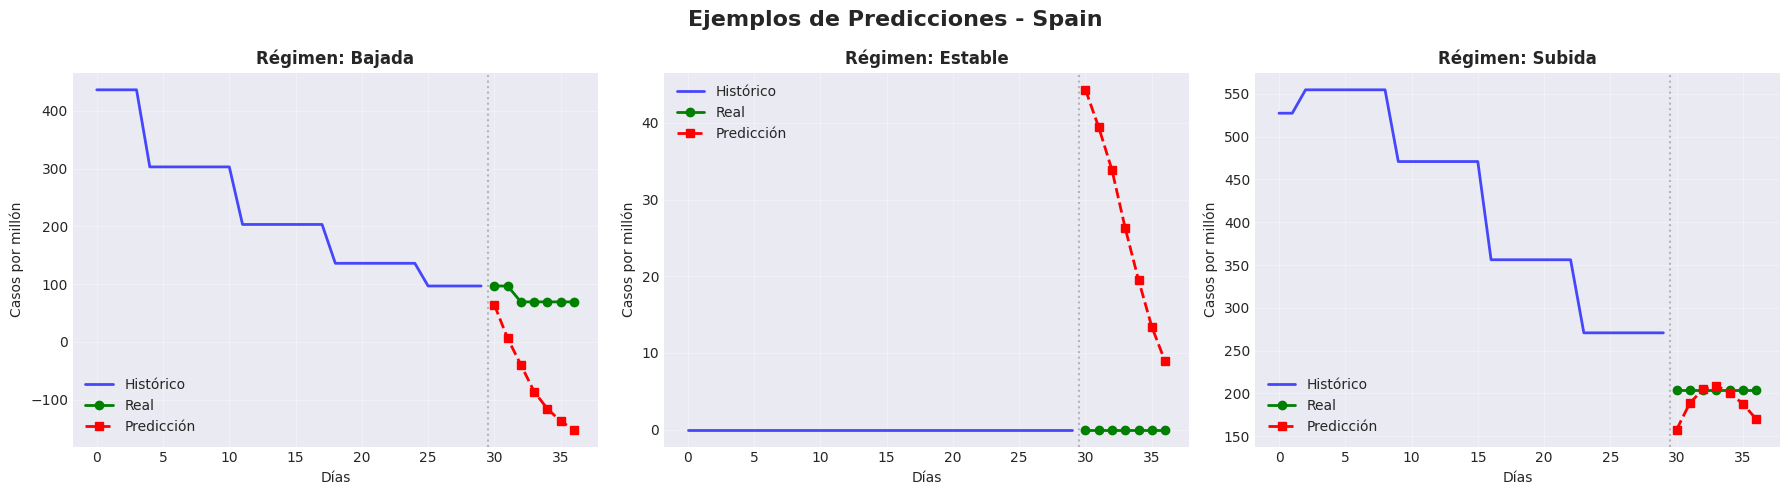

In [62]:
# Seleccionar ejemplos de cada régimen
ejemplos_por_regimen = {}
for regime_id in [0, 1, 2]:
    indices = np.where(regime_labels == regime_id)[0]
    if len(indices) > 0:
        # Seleccionar un ejemplo aleatorio
        idx = np.random.choice(indices)
        ejemplos_por_regimen[regime_id] = idx

# Visualizar ejemplos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Ejemplos de Predicciones - {PAIS_SELECCIONADO}', fontsize=16, fontweight='bold')

for i, (regime_id, idx) in enumerate(ejemplos_por_regimen.items()):
    ax = axes[i]
    
    # Datos históricos (ventana de entrada)
    historical = denormalize_data(X_sequences[idx, :, 0], data_min, data_max)
    x_hist = np.arange(len(historical))
    
    # Predicción y valores reales
    x_pred = np.arange(len(historical), len(historical) + OUTPUT_SIZE)
    
    # Plotear
    ax.plot(x_hist, historical, 'b-', linewidth=2, label='Histórico', alpha=0.7)
    ax.plot(x_pred, Y_sequences_original[idx], 'g-', linewidth=2, label='Real', marker='o')
    ax.plot(x_pred, predictions_original[idx], 'r--', linewidth=2, label='Predicción', marker='s')
    
    ax.set_title(f'Régimen: {regime_map[regime_id]}', fontweight='bold')
    ax.set_xlabel('Días')
    ax.set_ylabel('Casos por millón')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.axvline(x=len(historical)-0.5, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## 10. Predicción Secuencial

Visualizamos todas las predicciones a lo largo del tiempo y la evolución del régimen epidemiológico.

In [ ]:
### 10.1 Serie Temporal Completa con Predicciones

# Configuración de visualización
MOSTRAR_DATOS_ORIGINALES = True  # Mostrar datos originales además de los usados para inferencia

# Crear visualización de la serie temporal completa
fig, ax = plt.subplots(figsize=(20, 8))
titulo = f'Serie Temporal Completa con Predicciones del Modelo - {PAIS_SELECCIONADO}'
if USAR_MEDIA_MOVIL:
    titulo += f' (Inferencia con MA {VENTANA_MA}d)'
fig.suptitle(titulo, fontsize=16, fontweight='bold', y=0.995)

# Seleccionar cada N predicciones para no saturar el gráfico
step = max(1, len(predictions) // 50)
indices_to_plot = range(0, len(predictions), step)

# Datos históricos completos
cases_original = df_pais['new_cases_smoothed_per_million'].values

# Datos usados para la inferencia
if USAR_MEDIA_MOVIL:
    cases_inference = df_pais['new_cases_smoothed_per_million_ma'].values
    # Mostrar ambos: originales y con MA
    if MOSTRAR_DATOS_ORIGINALES:
        ax.plot(cases_original, color='lightblue', linewidth=1.5, label='Datos originales', alpha=0.5, zorder=1)
    ax.plot(cases_inference, 'b-', linewidth=2, label=f'Datos con MA {VENTANA_MA}d (usados para inferencia)', alpha=0.8, zorder=2)
else:
    cases_inference = cases_original
    ax.plot(cases_original, 'b-', linewidth=2, label='Datos reales', alpha=0.8, zorder=1)

# Predicciones seleccionadas (coloreadas por régimen)
# Crear una predicción por cada régimen para la leyenda
legend_plotted = {0: False, 1: False, 2: False}
regime_colors = {0: 'green', 1: 'orange', 2: 'red'}
regime_names_full = {0: 'Predicción (Régimen Bajada)', 
                     1: 'Predicción (Régimen Estable)', 
                     2: 'Predicción (Régimen Subida)'}

for idx in indices_to_plot:
    start_idx = WINDOW_SIZE + idx
    end_idx = start_idx + OUTPUT_SIZE
    x_pred = np.arange(start_idx, end_idx)
    
    regime = regime_labels[idx]
    color = regime_colors[regime]
    
    # Añadir label solo la primera vez para cada régimen
    if not legend_plotted[regime]:
        ax.plot(x_pred, predictions_original[idx], color=color, alpha=0.4, 
                linewidth=1.5, label=regime_names_full[regime], zorder=3)
        legend_plotted[regime] = True
    else:
        ax.plot(x_pred, predictions_original[idx], color=color, alpha=0.4, 
                linewidth=1.5, zorder=3)

ax.set_xlabel('Días desde el inicio', fontsize=12)
ax.set_ylabel('Casos por millón (suavizados)', fontsize=12)
subtitulo = 'Predicciones de 7 días realizadas en diferentes momentos del tiempo'
if USAR_MEDIA_MOVIL:
    subtitulo += f'\nLa inferencia se realizó usando datos suavizados con media móvil de {VENTANA_MA} días'
ax.set_title(subtitulo, fontsize=11, style='italic', pad=10)

# Mejorar la leyenda
ax.legend(loc='upper right', fontsize=10, framealpha=0.9, shadow=True)
ax.grid(alpha=0.3, linestyle='--')

# Añadir información adicional
textstr = f'Total predicciones: {len(predictions)}\nPredicciones mostradas: {len(list(indices_to_plot))}\nVentana histórica: {WINDOW_SIZE} días\nHorizonte predicción: {OUTPUT_SIZE} días'
if USAR_MEDIA_MOVIL:
    textstr += f'\n\nDatos de entrada:\nMedia móvil: {VENTANA_MA} días'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

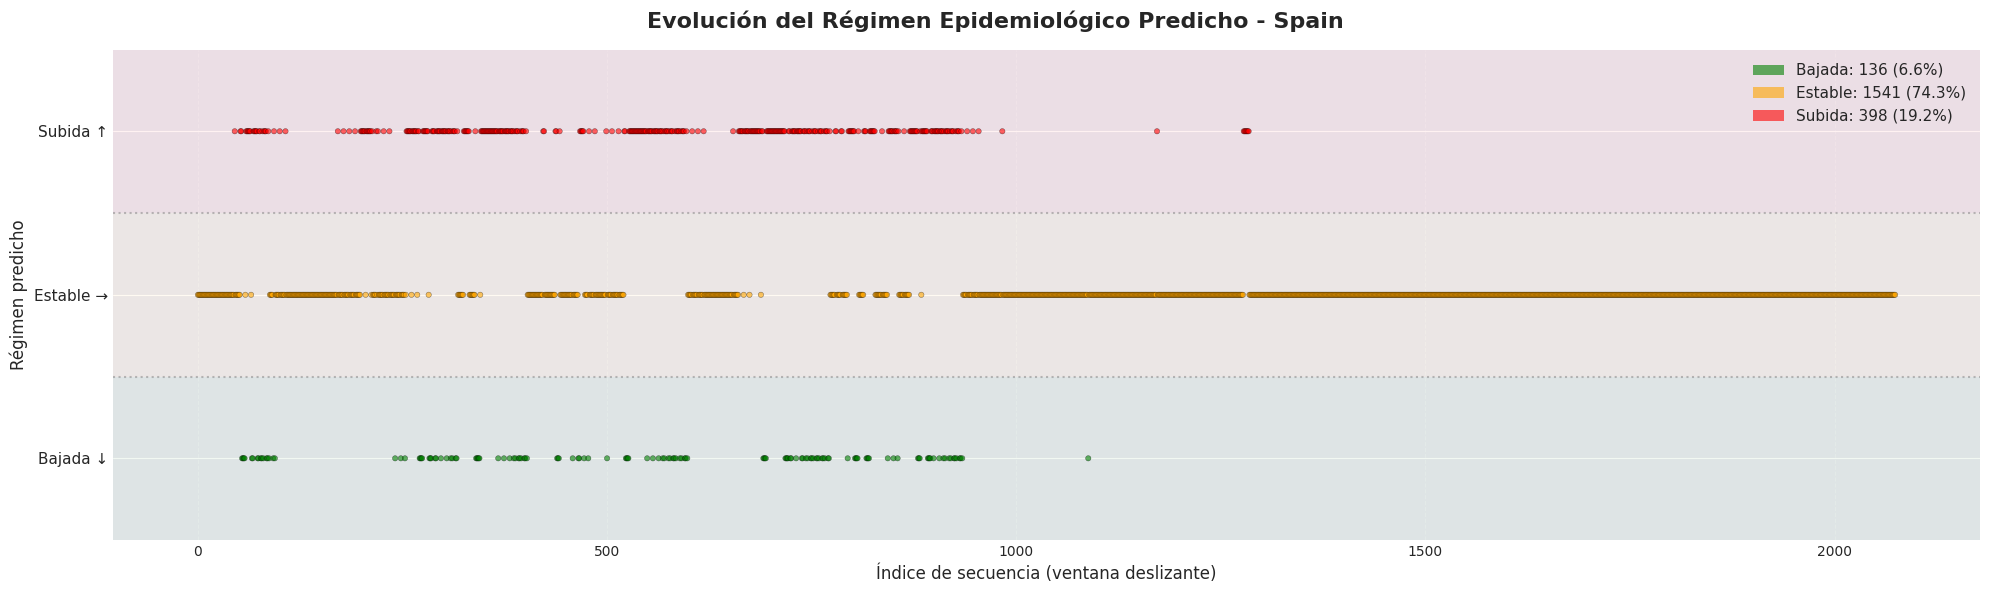

In [64]:
### 10.2 Evolución del Régimen Epidemiológico

# Crear visualización de la evolución del régimen
fig, ax = plt.subplots(figsize=(20, 6))
fig.suptitle(f'Evolución del Régimen Epidemiológico Predicho - {PAIS_SELECCIONADO}', 
             fontsize=16, fontweight='bold')

# Datos del régimen a lo largo del tiempo
regime_timeline = regime_labels

# Colores por régimen
colors_regime = ['green', 'orange', 'red']
color_list = [colors_regime[r] for r in regime_timeline]

# Scatter plot con colores
ax.scatter(range(len(regime_timeline)), regime_timeline, 
           c=color_list, alpha=0.6, s=15, edgecolors='black', linewidth=0.3)

# Configuración de ejes
ax.set_xlabel('Índice de secuencia (ventana deslizante)', fontsize=12)
ax.set_ylabel('Régimen predicho', fontsize=12)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Bajada ↓', 'Estable →', 'Subida ↑'], fontsize=11)
ax.grid(alpha=0.3, linestyle='--', axis='x')

# Añadir líneas horizontales para separar regímenes
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle=':', alpha=0.5)

# Colorear el fondo según régimen
ax.axhspan(-0.5, 0.5, facecolor='green', alpha=0.05)
ax.axhspan(0.5, 1.5, facecolor='orange', alpha=0.05)
ax.axhspan(1.5, 2.5, facecolor='red', alpha=0.05)

# Información de distribución
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, label=f'Bajada: {(regime_timeline == 0).sum()} ({(regime_timeline == 0).sum()/len(regime_timeline)*100:.1f}%)'),
    Patch(facecolor='orange', alpha=0.6, label=f'Estable: {(regime_timeline == 1).sum()} ({(regime_timeline == 1).sum()/len(regime_timeline)*100:.1f}%)'),
    Patch(facecolor='red', alpha=0.6, label=f'Subida: {(regime_timeline == 2).sum()} ({(regime_timeline == 2).sum()/len(regime_timeline)*100:.1f}%)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.9, shadow=True)

ax.set_ylim(-0.5, 2.5)

plt.tight_layout()
plt.show()

## 11. Análisis por Régimen

In [65]:
# Calcular métricas por régimen
print(f"\n{'='*70}")
print("MÉTRICAS POR RÉGIMEN")
print(f"{'='*70}\n")

for regime_id in [0, 1, 2]:
    mask = regime_labels == regime_id
    if mask.sum() > 0:
        mae_regime = np.abs(predictions[mask] - Y_sequences[mask]).mean()
        rmse_regime = np.sqrt(((predictions[mask] - Y_sequences[mask]) ** 2).mean())
        
        # Direction accuracy para este régimen
        pred_dir_regime = classify_trend(predictions[mask, -1] - predictions[mask, 0])
        true_dir_regime = classify_trend(Y_sequences[mask, -1] - Y_sequences[mask, 0])
        dir_acc_regime = (pred_dir_regime == true_dir_regime).mean() * 100
        
        print(f"Régimen: {regime_map[regime_id]}")
        print(f"  N secuencias: {mask.sum()}")
        print(f"  MAE: {mae_regime:.6f}")
        print(f"  RMSE: {rmse_regime:.6f}")
        print(f"  Direction Accuracy: {dir_acc_regime:.2f}%")
        print()


MÉTRICAS POR RÉGIMEN

Régimen: Bajada
  N secuencias: 136
  MAE: 0.058117
  RMSE: 0.084409
  Direction Accuracy: 11.03%

Régimen: Estable
  N secuencias: 1541
  MAE: 0.010804
  RMSE: 0.013035
  Direction Accuracy: 99.35%

Régimen: Subida
  N secuencias: 398
  MAE: 0.044498
  RMSE: 0.089994
  Direction Accuracy: 82.41%



print(f"\n{'='*70}")
print(f"RESUMEN DE INFERENCIA - {PAIS_SELECCIONADO}")
print(f"{'='*70}\n")

print(f"--- INFORMACIÓN DEL DATASET ---")
print(f"  Total de días: {len(df_pais)}")
print(f"  Rango de fechas: {df_pais['date'].min()} a {df_pais['date'].max()}")

print(f"\n--- CONFIGURACIÓN DEL MODELO ---")
print(f"  Total de secuencias: {len(X_sequences)}")
print(f"  Tamaño de ventana: {WINDOW_SIZE} días")
print(f"  Horizonte de predicción: {OUTPUT_SIZE} días")
if USAR_MEDIA_MOVIL:
    print(f"  Media móvil aplicada: {VENTANA_MA} días")
else:
    print(f"  Media móvil: No aplicada")
print(f"  Cluster ID usado: {cluster_id_default}")

print(f"\n--- DISTRIBUCIÓN DE REGÍMENES PREDICHOS ---")
for regime_id, count in zip(unique, counts):
    print(f"  {regime_map[regime_id]}: {count} ({count/len(regime_labels)*100:.1f}%)")

print(f"\n--- MÉTRICAS DEL CLASIFICADOR XGBoost (Etapa 1) ---")
print(f"  Accuracy global: {xgboost_accuracy:.2f}%")
print(f"  Accuracy por régimen (recall):")
print(f"    Bajada:  {class_report['Bajada']['recall']*100:.2f}%")
print(f"    Estable: {class_report['Estable']['recall']*100:.2f}%")
print(f"    Subida:  {class_report['Subida']['recall']*100:.2f}%")
print(f"  F1-Score por régimen:")
print(f"    Bajada:  {class_report['Bajada']['f1-score']*100:.2f}%")
print(f"    Estable: {class_report['Estable']['f1-score']*100:.2f}%")
print(f"    Subida:  {class_report['Subida']['f1-score']*100:.2f}%")

print(f"\n--- MÉTRICAS DEL PREDICTOR LSTM (Etapa 2) ---")
print(f"  MAE (normalizado): {mae:.6f}")
print(f"  RMSE (normalizado): {rmse:.6f}")
print(f"  MAE (original): {mae_original:.2f} casos por millón")
print(f"  RMSE (original): {rmse_original:.2f} casos por millón")
print(f"  Direction Accuracy: {direction_accuracy:.2f}%")

print(f"\n--- MÉTRICAS GLOBALES DEL MODELO HÍBRIDO ---")
print(f"  Clasificación correcta de régimen: {xgboost_accuracy:.2f}%")
print(f"  Precisión en magnitud (MAE): {mae_original:.2f} casos/millón")
print(f"  Dirección correcta de tendencia: {direction_accuracy:.2f}%")

print(f"\n{'='*70}")
print("✓ Inferencia completada exitosamente")
print(f"{'='*70}")

In [66]:
print(f"\n{'='*70}")
print(f"RESUMEN DE INFERENCIA - {PAIS_SELECCIONADO}")
print(f"{'='*70}\n")

print(f"Datos del país:")
print(f"  Total de días: {len(df_pais)}")
print(f"  Rango de fechas: {df_pais['date'].min()} a {df_pais['date'].max()}")
print(f"\nVentanas de predicción:")
print(f"  Total de secuencias: {len(X_sequences)}")
print(f"  Tamaño de ventana: {WINDOW_SIZE} días")
print(f"  Horizonte de predicción: {OUTPUT_SIZE} días")

print(f"\nDistribución de regímenes:")
for regime_id, count in zip(unique, counts):
    print(f"  {regime_map[regime_id]}: {count} ({count/len(regime_labels)*100:.1f}%)")

print(f"\nMétricas globales:")
print(f"  MAE (normalizado): {mae:.6f}")
print(f"  RMSE (normalizado): {rmse:.6f}")
print(f"  MAE (original): {mae_original:.2f} casos por millón")
print(f"  RMSE (original): {rmse_original:.2f} casos por millón")
print(f"  Direction Accuracy: {direction_accuracy:.2f}%")

print(f"\n{'='*70}")
print("✓ Inferencia completada exitosamente")
print(f"{'='*70}")


RESUMEN DE INFERENCIA - Spain

Datos del país:
  Total de días: 2111
  Rango de fechas: 2020-01-01 a 2025-12-28

Ventanas de predicción:
  Total de secuencias: 2075
  Tamaño de ventana: 30 días
  Horizonte de predicción: 7 días

Distribución de regímenes:
  Bajada: 136 (6.6%)
  Estable: 1541 (74.3%)
  Subida: 398 (19.2%)

Métricas globales:
  MAE (normalizado): 0.020368
  RMSE (normalizado): 0.046331
  MAE (original): 58.19 casos por millón
  RMSE (original): 132.37 casos por millón
  Direction Accuracy: 90.31%

✓ Inferencia completada exitosamente
